# Identifying Similar Questions

## XGBoost

Link to Data: https://www.kaggle.com/mysarahmadbhat/quora-questions-duplicacy

## Notebook Results

| Model                         | True Positive | True Negative  | False Positive | False Negative | Accuracy | Precision | Recall | F1-Score | AOC AUC | Log Loss |
|-------------------------------|---------------|----------------|----------------|----------------|----------|-----------|--------|----------|---------|----------|
| XGBoost (Original Embeddings) |**2539**       |**5533**        |**1088**        |**840**         |**0.8072**|**0.7514** | **0.7000**|**0.7248**|**0.8801**|**0.4149**|
| XGBoost (Cleaned Embeddings)  | 2141          | 5376           | 1486           | 997            | 0.7517   | 0.6823    | 0.5903 | 0.6330   | 0.8194  | 0.4942   |

**Imports**

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

**Import the datasets**

In [24]:
df = pd.read_csv('../quora_preprocessed_embeddings.csv')
df_cleaned = pd.read_csv('../quora_cleaned_preprocessed_embeddings.csv')

In [25]:
df['is_duplicate'] = df['is_duplicate'].astype(int) 
df_cleaned['is_duplicate'] = df_cleaned['is_duplicate'].astype(int) 

In [26]:
df.head()

,question1,question2,question1_wc,question2_wc,0,1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,is_duplicate
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,8,8,0.405561,0.351042,0.145522,1.000624,-0.327835,-0.690683,...,0.324852,-0.490256,-0.671185,0.091470,0.934359,0.534707,-0.032896,-0.541392,-1.225177,0
1,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,11,9,0.300924,-0.955288,-0.028438,-0.057767,-0.116978,0.664040,...,-0.696291,-0.581999,-2.126769,0.236446,0.657223,-0.261457,0.327333,-0.159874,-0.559062,0
2,Which is more advisable and better material fo...,What is the best server setup for buddypress?,16,8,0.394129,-0.020451,0.822735,0.161385,0.290848,0.527879,...,-0.211299,-0.892678,-1.750959,0.175476,0.429432,0.389655,0.212048,0.102080,-0.588654,0
3,How do I improve logical programming skills?,How can I improve my logical skills for progra...,7,9,0.256092,-1.279762,0.247349,-0.618753,0.534039,0.612880,...,-0.398293,-0.139095,-0.957269,0.427750,0.424172,0.942060,0.083971,-1.021245,-0.237951,1
4,How close we are to see 3rd world war?,How close is a World War III?,9,7,0.348143,0.070992,0.533568,0.676788,0.621202,-0.213371,...,0.887324,-1.132204,-0.505966,0.084157,-0.245989,0.200148,0.362305,-0.552422,-0.970416,1


In [27]:
df_cleaned.head()

,question1_cleaned,question2_cleaned,question1_cleaned_wc,question2_cleaned_wc,0,1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,is_duplicate
0,play pokémon go korea,play pokémon go china,4,4,0.099863,0.804212,0.457976,1.360421,-0.439485,-0.542794,...,0.198325,-0.638950,-0.256670,-0.147607,0.427118,0.315945,-0.052933,-0.446774,-0.929896,0
1,best side dish crab cake,good side dish buffalo chicken,5,5,0.579055,-0.467236,-0.014480,0.050153,-0.338045,0.431639,...,-0.860721,-0.555505,-1.613838,-0.139364,0.284707,-0.446280,0.189698,-0.195710,-0.583254,0
2,advis better materi crash test automobil ducti...,best server setup buddypress,8,4,0.295399,-0.071162,0.662856,0.133914,-0.059055,0.359554,...,-0.308801,-0.583140,-1.033460,0.000881,-0.071482,-0.163930,-0.425215,0.229150,-0.357686,0
3,improv logic program skill,improv logic skill program,4,4,-0.179769,-0.170566,0.261266,-0.477791,-0.310139,0.050823,...,-1.031234,-0.424010,-1.140022,-0.059757,0.505181,0.662573,0.303810,-0.766564,0.073204,1
4,close see world war,close world war iii,4,4,0.013538,0.066066,1.023784,0.517954,0.606080,0.089296,...,0.170532,-1.291750,0.085144,-0.049792,-0.246931,0.490173,0.197307,-0.669707,-0.590559,1


**Splitting the data into training and testing sets**

In [28]:
num_samples = df.shape[0]
training_samples = int(num_samples * 0.9)
testing_samples = int(num_samples * 0.1)
print('{} number of samples'.format(num_samples))
print('{} training samples'.format(training_samples))
print('{} testing samples'.format(num_samples - training_samples))

100000 number of samples
90000 training samples
10000 testing samples


I am shuffling and splitting the dataset manually in order to preserve the questions in the same index as the embeddings. This will allow me to look at which questions I got wrong by comparing indexes of the incorrect predictions and finding the questions themselves.

I will also be excluding the word counts because of the large amount of features already in the dataset. Inclusing the word counts will not have a significant effect.

In [29]:
### Shuffle both datasets
df_suffled = df.sample(frac=1, random_state=42).reset_index(drop=True).copy()
df_cleaned_suffled = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True).copy()

In [30]:
### Original Dataset

questions = df_suffled[df_suffled.columns[:2]]
embeddings = df_suffled[df_suffled.columns[4:-1]] ### Exclusing the word counts
labels = df_suffled['is_duplicate'].astype(int)

X_train = embeddings[:training_samples]
X_train_qs = questions[:training_samples]
y_train = labels[:training_samples]
X_test = embeddings[training_samples:]
X_test_qs = questions[training_samples:]
y_test = labels[training_samples:]

### Cleaned Dataset

questions_cleaned = df_cleaned_suffled[df_cleaned_suffled.columns[:2]]
embeddings_cleaned = df_cleaned_suffled[df_cleaned_suffled.columns[4:-1]] ### Exclusing the word counts
labels_cleaned = df_cleaned_suffled['is_duplicate'].astype(int)

X_train_cleaned = embeddings_cleaned[:training_samples]
X_train_qs_cleaned = questions_cleaned[:training_samples]
y_train_cleaned = labels_cleaned[:training_samples]
X_test_cleaned = embeddings_cleaned[training_samples:]
X_test_qs_cleaned = questions_cleaned[training_samples:]
y_test_cleaned = labels_cleaned[training_samples:]

### Create a validation set of 20,000 from the training data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=20000)
X_train_cleaned, X_val_cleaned, y_train_cleaned, y_val_cleaned = train_test_split(X_train_cleaned, y_train_cleaned, test_size=20000)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_train_cleaned.shape)
print(y_train_cleaned.shape)
print(X_val_cleaned.shape)
print(y_val_cleaned.shape)

(70000, 2048)
(70000,)
(20000, 2048)
(20000,)
(70000, 2048)
(70000,)
(20000, 2048)
(20000,)


## XGBoost
Original, Unbalanced

In [31]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbose=0)
xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_val, y_val)], 
        early_stopping_rounds=10, 
        eval_metric="logloss",
        verbose=False)
### Make predictions on the testing data
y_prob = xgb.predict_proba(X_test)
y_pred = np.argmax(y_prob, axis=1)

[16:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




**Checking for metrics**

Below I create two functions to help visuals some important metrics to gauge each machine models performance. 

In [32]:
def calc_precision_recall(y_true, y_pred):
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)  
    # Instantiate counters
    TP = FP = FN = 0
    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1    
    # Calculate true positive rate and false positive rate
    precision = (TP / (TP + FP)) if (TP + FP != 0) else 1
    recall = (TP / (TP + FN)) if (TP + FN != 0) else 1
    return precision, recall
calc_precision_recall(y_test, y_pred)

def print_metrics(y_test, y_pred, y_prob, model_name):
    
    target_names=['Duplicate','Not Duplicate']
    
    tp = ((y_test==1) & (y_pred==1)).sum()
    tn = ((y_test==0) & (y_pred==0)).sum()
    fp = ((y_test==1) & (y_pred==0)).sum()
    fn = ((y_test==0) & (y_pred==1)).sum()
    
    precision , recall = calc_precision_recall(y_test, y_pred)
    
    print("True Positive:",tp)
    print("True Negative:",tn)
    print("False Positive (Type 1 error):",fp)
    print("False Negative (Type 2 error):",fn)
    print("Accuracy: {:.4f}".format((y_pred == y_test).mean()))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format((2*precision*recall)/(precision+recall)))
    print("Log Loss: {:.4f}".format(log_loss(y_test, y_prob)))
    
    # Containers for true positive / false positive rates
    precision_scores = []
    recall_scores = []

    # Define probability thresholds to use, between 0 and 1
    probability_thresholds = np.linspace(0, 1, num=100)

    # Find true positive / false positive rate for each threshold
    for p in probability_thresholds:
        y_test_preds = []
        for prob in y_prob[:,1]:
            if prob > p:
                y_test_preds.append(1)
            else:
                y_test_preds.append(0)
        precision, recall = calc_precision_recall(y_test, y_test_preds)
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    ### Starting Visuals
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    
    ### Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame([cm[1][::-1],cm[0][::-1]]), 
                square=True, 
                annot=True, 
                fmt='d', 
                cbar=False, 
                xticklabels=['Duplicate\n(1)','Not Duplicate\n(0)'], 
                yticklabels=['Duplicate (1)','Not Duplicate (0)'], 
                cmap="YlGnBu",
                ax=axes[0])
    plt.sca(axes[0])
    plt.title("Predicted Value")
    plt.yticks(horizontalalignment='right', rotation=0)
    plt.ylabel("True\nValue", rotation=0)

    ### ROC AUC 
    roc_score = "ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob[:, 1]))
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    # plot model roc curve
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].plot(fpr, tpr, marker='.', label=roc_score)
    plt.sca(axes[1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Postivie Rate')
    plt.legend()
    
    ### Precision Recall
    baseline = len(y_test[y_test==1]) / len(y_test)
    axes[2].plot(recall_scores, precision_scores, label=model_name)
    axes[2].plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.sca(axes[2])
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    fig.tight_layout()

True Positive: 2539
True Negative: 5533
False Positive (Type 1 error): 1088
False Negative (Type 2 error): 840
Accuracy: 0.8072
Precision: 0.7514
Recall: 0.7000
F1-Score: 0.7248
Log Loss: 0.4149


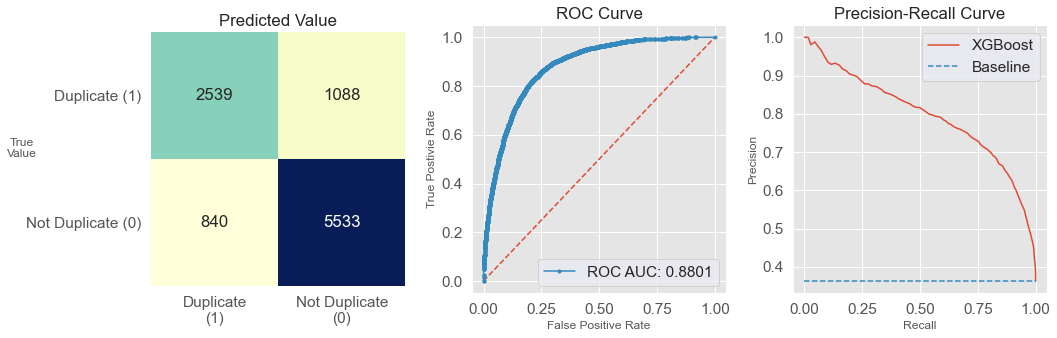

In [33]:
print_metrics(y_test, y_pred, y_prob, 'XGBoost')

**Looking at the questions the model incorrectly predicted**

Below I created a function to print out *n* amount of wrong answers from both kinds of errors

In [34]:
def print_wrong_responses(y_test, y_pred, X_test_qs, n=5):
    print("""##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 0) & (y_pred == 1)].index[:n]]
    
    print("""##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 1) & (y_pred == 0)].index[:n]]

In [35]:
print_wrong_responses(y_test, y_pred, X_test_qs, n=5)

##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)

Question 1:How do I remove a ROM virus on android?
Question 2:How do I remove Spyware, Malware and viruses from my Android tablet? 

Question 1:What are the questions asked in SSB interviews?
Question 2:What questions are asked in an NDA SSB interview? 

Question 1:What are the best books by Indian authors?
Question 2:What are some good Indian novels? 

Question 1:What are some mind-blowing futuristic gadgets that exist that most people don't know about?
Question 2:What are some mind-blowing wallets gadgets that exist that most people don't know about? 

Question 1:What are the most famous novels?
Question 2:What are the most famous novels in each country? 

##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)

Question 1:What are the latest off page a

## XGBoost
Cleaned dataset

In [36]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbose=0)
xgb.fit(X_train_cleaned, 
        y_train_cleaned, 
        eval_set=[(X_val_cleaned, y_val_cleaned)], 
        early_stopping_rounds=10, 
        eval_metric="logloss",
        verbose=False)
### Make predictions on the testing data
y_prob = xgb.predict_proba(X_test_cleaned)
y_pred = np.argmax(y_prob, axis=1)

[16:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




True Positive: 2141
True Negative: 5376
False Positive (Type 1 error): 1486
False Negative (Type 2 error): 997
Accuracy: 0.7517
Precision: 0.6823
Recall: 0.5903
F1-Score: 0.6330
Log Loss: 0.4942


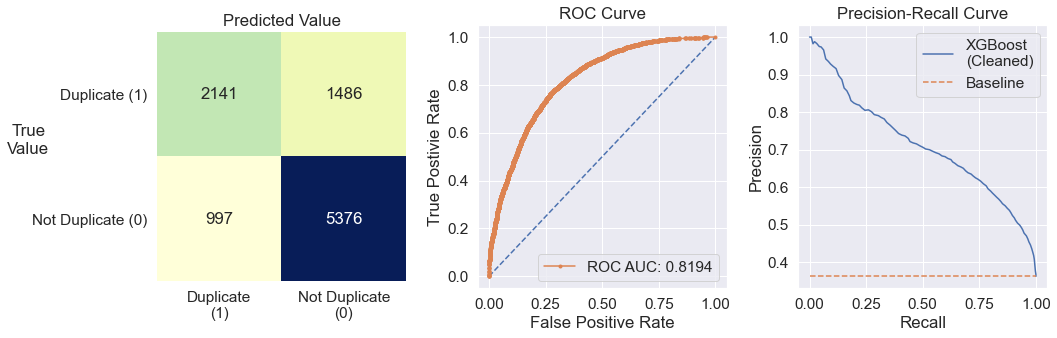

In [37]:
print_metrics(y_test, y_pred, y_prob, 'XGBoost\n(Cleaned)')

In [38]:
print_wrong_responses(y_test, y_pred, X_test_qs, n=5)

##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)

Question 1:What are the questions asked in SSB interviews?
Question 2:What questions are asked in an NDA SSB interview? 

Question 1:What are the best technology inventions of 2014?
Question 2:What are the best technology inventions? 

Question 1:Can I make 30,000 a month playing poker?
Question 2:Can I make 900k a year playing poker online? Why or why not? 

Question 1:What are the best books by Indian authors?
Question 2:What are some good Indian novels? 

Question 1:What are some mind-blowing futuristic gadgets that exist that most people don't know about?
Question 2:What are some mind-blowing wallets gadgets that exist that most people don't know about? 

##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)

Question 1:How do you determine the valu